In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack
from scipy.stats import poisson, norm
from scipy.stats import t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

Z score:  3.4661629670697414
Poisson p-value single tail:  0.0008444930803583883
Gaussian p-value single tail:  0.00026397158691493505
Gaussian p-value single tail, alternative method using Z:  0.00026397158691493505


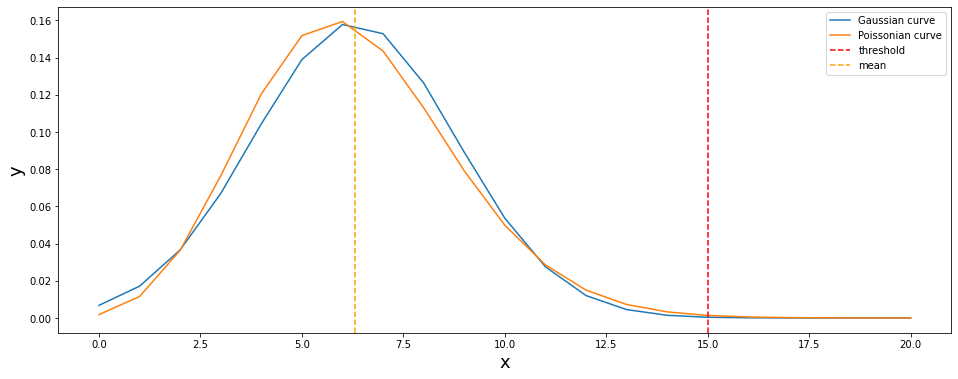

In [2]:
x = np.arange(21)

z = (15 - 6.3)/np.sqrt(6.3)
print("Z score: ", z)

ypois = poisson.pmf(x, 6.3)
intp = 1 - poisson.cdf(15, 6.3)
print("Poisson p-value single tail: ", intp)

sigma = np.sqrt(6.3)
ygaus = norm.pdf(x, 6.3, sigma)
intg = 1 - norm.cdf(15, 6.3, sigma)
print("Gaussian p-value single tail: ", intg)

##alternative method
intgg = 1 - norm.cdf(z, 0, 1)
print("Gaussian p-value single tail, alternative method using Z: ", intgg)

fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(x, ygaus, label= "Gaussian curve")
ax.plot(x, ypois, label= "Poissonian curve")

ax.axvline(15, linestyle="--", color = "red" , label= "threshold")
ax.axvline(6.3, linestyle="--", color ="orange" , label= "mean")

ax.set_ylabel("y", fontsize = 18)
ax.set_xlabel("x", fontsize = 18)
ax.legend(loc="best")
plt.show()

**comment**

Since Z is greater than 3, this means that the value is farther than 3$\sigma$ from the mean and we consider it to be an outlier.

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

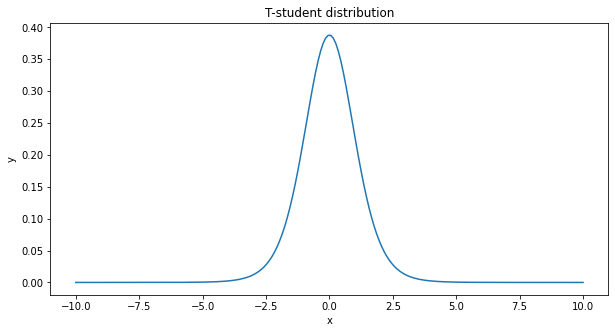

values of error and T-student: 14.813844875656017, -3.9918463262921122
T-student p-value double tail:  0.0031489409354536393


In [3]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

sigma_pre = np.std(pre)
sigma_post = np.std(post)
sigma = np.sqrt(sigma_pre**2 + sigma_post**2)
n = len(pre)
T = (pre.mean() - post.mean())*np.sqrt(n)/sigma

x = np.linspace(-10, 10, 200)

yt = t.pdf(x, n - 1)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(x, yt)
ax.set_title("T-student distribution")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.show()

pvalue = t.cdf(T, n - 1) + (1. - t.cdf(-T, n - 1))
print("values of error and T-student: {}, {}".format(sigma, T))
print("T-student p-value double tail: ", pvalue)

**comment**

Since the p-value is lower than half the level of significance (the latter set at 5%), we reject the null hypothesis, meaning that the change in blood pressure is statistically significant.

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

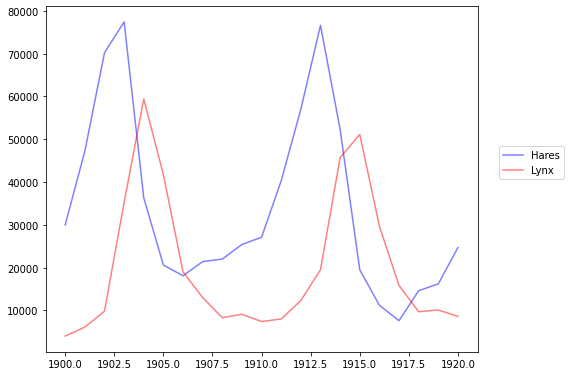

Peak frequency hares:  0.09523809523809523
Period hares:  10.5
Peak frequency lynxes:  0.09523809523809523
Period lynxes:  10.5


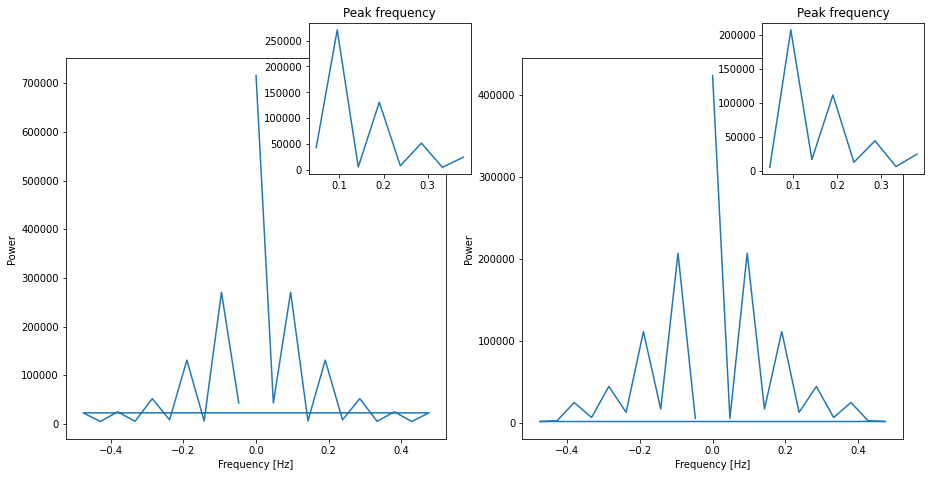

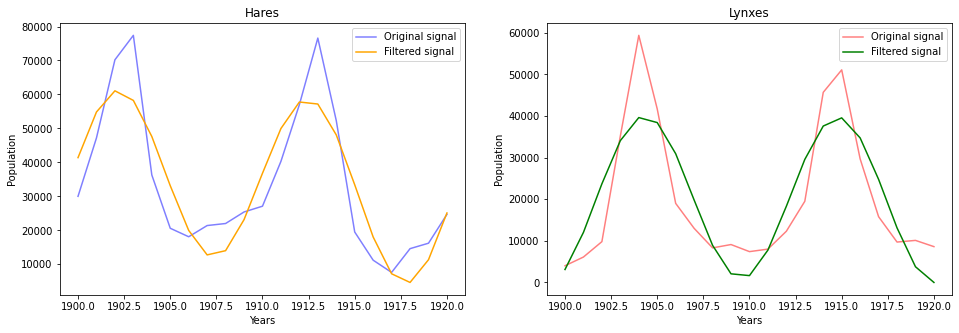

In [4]:
data = np.loadtxt("populations.txt")
year, hares, lynxes, carrots = data.T # trick: columns to variables

plt.figure(figsize=(12,6))
plt.axes([0.2, 0.1, 0.5, 0.8]) 
plt.plot(year, hares, alpha = 0.5, color = "blue")
plt.plot(year, lynxes, alpha = 0.5, color = "red")
plt.legend(("Hares", "Lynx"), loc=(1.05, 0.5)) 
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))

h_fft = fftpack.fft(hares)
h_power = np.abs(h_fft)
h_freq = fftpack.fftfreq(hares.size, d = 1)
ax1.plot(h_freq, h_power)
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Power")

# Find the peak frequency: focus only on only the positive frequencies
h_mask = np.where(h_freq > 0)
h_freqs = h_freq[h_mask]
h_powes = h_power[h_mask]
# find the max of freqs array
h_peak_freq = h_freqs[h_powes.argmax()]
print("Peak frequency hares: ", h_peak_freq)
print("Period hares: ", 1/h_peak_freq)


# An inner plot to show the peak frequency
ax3 = fig.add_axes([0.35, 0.65, 0.15, 0.3])
#ax3 = ax1.twinx()
ax3.plot(h_freqs[:8], h_powes[:8])
ax3.set_title("Peak frequency")

l_fft = fftpack.fft(lynxes)
l_power = np.abs(l_fft)
l_freq = fftpack.fftfreq(lynxes.size, d = 1)
ax2.plot(l_freq, l_power)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power")

# Find the peak frequency: focus only on only the positive frequencies
l_mask = np.where(l_freq > 0)
l_freqs = l_freq[l_mask]
l_powes = l_power[l_mask]
# find the max of freqs array
l_peak_freq = l_freqs[l_powes.argmax()]
print("Peak frequency lynxes: ", l_peak_freq)
print("Period lynxes: ", 1/l_peak_freq)


# An inner plot to show the peak frequency
ax4 = fig.add_axes([0.77, 0.65, 0.15, 0.3])
ax4.plot(l_freqs[:8], l_powes[:8])
ax4.set_title("Peak frequency")

plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))

high_freq_fft = h_fft.copy()
high_freq_fft[np.abs(h_freq) > h_peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)
real_filtered_signal = np.real(filtered_sig)

ax1.set_title("Hares")
ax1.plot(year, hares, alpha = 0.5, label = "Original signal", color = "blue")
ax1.plot(year, real_filtered_signal, label = "Filtered signal", color = "orange")
ax1.set_xlabel("Years")
ax1.set_ylabel("Population")
ax1.legend(loc= "best")

high_freq_fft = l_fft.copy()
high_freq_fft[np.abs(l_freq) > l_peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)
real_filtered_signal = np.real(filtered_sig)

ax2.set_title("Lynxes")
ax2.plot(year, lynxes, alpha = 0.5, label = "Original signal", color = "red")
ax2.plot(year, real_filtered_signal, label = "Filtered signal", color = "green")
ax2.set_xlabel("Years")
ax2.set_ylabel("Population")
ax2.legend(loc= "best")


plt.show()

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

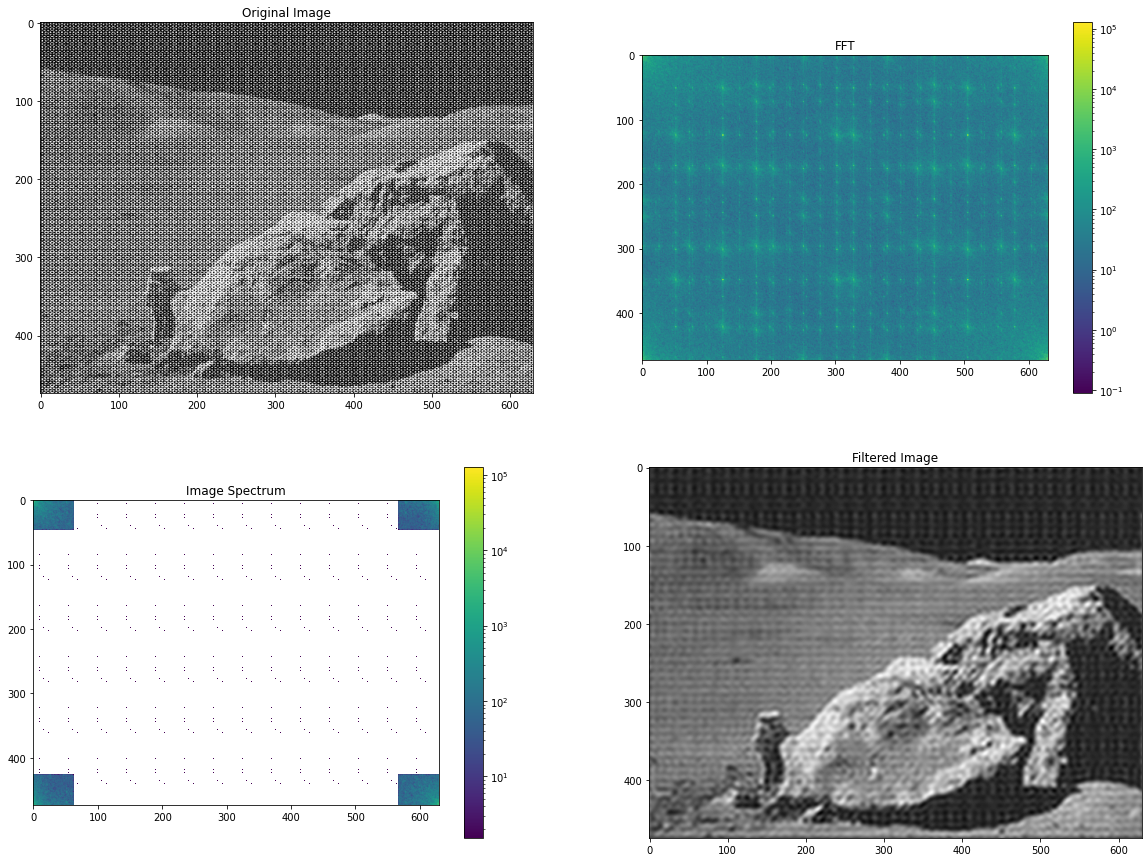

In [5]:
import numpy as np
import pylab
from scipy.fftpack import fft2, ifft2, fftshift
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

image = plt.imread("moonlanding.png")
ax1.imshow(image, cmap = "gray")
ax1.set_title("Original Image")


fft_im = fftpack.fft2(image)
power = np.abs(fft_im)
im2 = ax2.imshow(power, norm=LogNorm())
fig.colorbar(im2, ax = ax2)
ax2.set_title("FFT")


fft_new = fft_im.copy()

kf = 0.1

r, c = fft_new.shape
fft_new[int(r*kf):-int(r*kf), :] = 0
fft_new[:, int(c*kf):-int(c*kf)] = 0

power_new = np.abs(fft_new)

im3 = ax3.imshow(power_new, norm=LogNorm())
fig.colorbar(im3, ax = ax3)
ax3.set_title("Image Spectrum")

filtered_sig = fftpack.ifft2(fft_new)
real_filtered_signal = np.real(filtered_sig)

im4 = ax4.imshow(real_filtered_signal, cmap = "gray")
ax4.set_title("Filtered Image")
plt.show()
